In [774]:


import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import numpy as np





In [775]:
config = {
    "lr":0.001,
    "prot_aug":True,
    "subcenter_margin":0.28,
    "subcenters":3,
    "backbone":"rn18",
    "pretrained":False,
}

In [776]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable


In [777]:
import timm
from resnetpass import resnet18_cbam


if config['backbone'] == 'efficientnet':
    model = timm.create_model('efficientnet_b3', pretrained=config['pretrained'])
    model.classifier = nn.Linear(model.classifier.in_features, 512)
elif config['backbone'] == 'efficientnetv2':
    model = torchvision.models.efficientnet_v2_s()
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 512)
elif config['backbone'] == 'rn18':
    model = resnet18_cbam(pretrained=False)
    model.fc = nn.Linear(512,512)

In [778]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [779]:
import torchsummary

torchsummary.summary(model, (3, 224, 224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
              ReLU-9         [-1, 64, 224, 224]               0
       BasicBlock-10         [-1, 64, 224, 224]               0
           Conv2d-11         [-1, 64, 224, 224]          36,864
      BatchNorm2d-12         [-1, 64, 224, 224]             128
             ReLU-13         [-1, 64, 224, 224]               0
           Conv2d-14         [-1, 64, 2

In [780]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [781]:
device = torch.device('cuda:0')
class_order_file = 'class_order.pth'

In [782]:
!pip install pytorch-metric-learning

Defaulting to user installation because normal site-packages is not writeable


In [783]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [784]:
!pwd

/home/ubuntu/lialib/colab


In [785]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA Graphics Device', major=8, minor=9, total_memory=16076MB, multi_processor_count=80)

In [786]:
#model.load_state_dict(model_state_dict['rn18'])
import os

if os.path.isfile(class_order_file ):
    class_order = torch.load(class_order_file)
else:
    class_order = torch.randperm(100)
    torch.save(class_order,class_order_file)

In [787]:
class_order

tensor([27, 16, 74, 19, 36, 39, 31, 95, 35, 70, 51, 99, 38, 15, 49, 13, 52, 33,
         0, 84, 96, 73, 92, 40, 60, 54, 83, 75, 68, 76, 50,  4, 71, 20, 77, 59,
         6, 42, 26, 22,  1, 97, 21, 58, 18, 85, 28, 34, 24, 69, 55, 81, 46, 94,
        41, 25, 47, 45, 93, 67, 89, 32,  8, 63, 30,  2, 91, 23, 90, 44, 65, 53,
        66,  7, 61, 14, 82, 72, 56, 29, 12, 64,  9,  3, 86, 88, 98, 78, 80, 79,
        57, 11,  5, 43, 87, 62, 48, 10, 17, 37])

In [788]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [789]:
ds_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=preprocess)
ds_test  = datasets.CIFAR100(root='./data', train=False, download=True, transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [790]:
def instances_from_classes(dataset, class_order):
    subset = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label in class_order:
            subset.append(i)
    return subset


In [791]:
set_train = instances_from_classes(ds_train,class_order[:50])
set_test  = np.array(instances_from_classes(ds_test, class_order[:50]))

In [792]:
set_test.shape

(5000,)

In [793]:
sub_sample_train = sorted(np.random.permutation(set_train)[:300])
sub_sample_test  = sorted(np.random.permutation(set_test)[:300])

In [794]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_train))
dl_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_test))
dl_sub_train = torch.utils.data.DataLoader(ds_train,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_train))
dl_sub_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_test))

In [795]:
x,y = next(iter(dl_train))

In [796]:
y.shape

torch.Size([64])

In [797]:
y

tensor([85, 52, 39,  0, 74, 42, 95, 97, 35,  4, 84, 58, 18, 52, 96,  4, 58, 28,
        35,  4, 34, 95, 77, 68, 97, 13,  6, 27, 27, 22, 58, 85, 73,  6, 76, 27,
        60, 39, 33, 36, 18, 51, 54, 27, 50, 68, 68, 34, 71, 33, 20,  6, 50, 49,
        69, 35, 52, 39,  6, 59, 34, 33,  6,  4])

In [798]:
from pytorch_metric_learning import losses
loss_func = losses.SubCenterArcFaceLoss(num_classes=100,embedding_size=512,margin=config['subcenter_margin'],sub_centers=config['subcenters'])


In [799]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [800]:
import wandb

In [801]:
wandb.init(
    # set the wandb project where this run will be logged
    project="dmil+prot+subcenter",
    config=config
)

accuracy,▁▆▇▇█
f1,▁▆▇▇█
loss_train,█▆▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▆▇██
recall,▁▇▇▇█
accuracy,0.4
f1,0.38482
loss_train,0.00125
precision,0.43503
recall,0.42431


In [802]:

opt = optim.Adam(model.parameters(),lr=config['lr'])

In [803]:
scheduler = optim.lr_scheduler.MultiStepLR(opt,milestones=[45,90],gamma=0.1)

In [804]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [805]:
emb_batch = model(x.to(device))

In [806]:
from sklearn.manifold import TSNE

In [807]:
# given a batch of instances create a surrounding sample of instances
def create_surrounding_batch(batch,batch_y, num_surrounding=100, size=0.001):
    surrounding_batch = []
    surrounding_batch_y = []
    for i in range(len(batch)):
        
        instances_sorrounding = batch[i]+(torch.randn(num_surrounding,512)*size).to(batch.device)
        surrounding_batch.append(instances_sorrounding)
        surrounding_batch_y.append(batch_y[i].repeat(num_surrounding))
    return torch.cat(surrounding_batch), torch.cat(surrounding_batch_y)

In [808]:
batch_emb, batch_y = create_surrounding_batch(emb_batch,y)

In [809]:
batch_emb.shape

torch.Size([6400, 512])

In [810]:
batch_y.shape

torch.Size([6400])

In [811]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [812]:
from matplotlib import cm
import matplotlib.pyplot as plt

In [813]:
def tsne_proj(batch_emb, batch_y):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())
    cmap = cm.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(15,15))
    num_categories = 100
    for lab in range(num_categories):
        if lab in batch_y:
            indices = batch_y==lab
            ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()

In [814]:
#tsne_proj(batch_emb,batch_y)

In [815]:
def get_embeddings(lmodel,dl):
    lmodel.to(device)
    loop = tqdm(dl)
    lpred = []
    ly = []
    with torch.no_grad():
        for x,y in loop:
            x = x.to(device)
            y = y.to(device)
            pred = lmodel(x)
            lpred = lpred+pred.tolist()
            ly    = ly + y.tolist()
    return lpred,ly

In [816]:
import sklearn.neighbors as neighbors

In [817]:
from sklearn.metrics import classification_report

In [818]:
def pred_knn_model(model,dl_local_train,dl_local_test):
    train_emb,train_y = get_embeddings(model,dl_local_train)
    test_emb,test_y   = get_embeddings(model,dl_local_test)
    train_emb  = np.array(train_emb)
    train_y    = np.array(train_y)
    test_emb   = np.array(test_emb)
    test_y     = np.array(test_y)
    clf = neighbors.KNeighborsClassifier(n_neighbors=3,weights='distance')
    clf.fit(train_emb,train_y.T)
    pred = clf.predict(test_emb)
    return pred,test_y


In [819]:
pred,test_y = pred_knn_model(model,dl_sub_train,dl_sub_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 91.88it/s]


In [820]:
pred.shape,test_y.T.shape

((300,), (300,))

In [821]:
print(classification_report(test_y.T,pred))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.17      0.33      0.22         3
           4       0.00      0.00      0.00         3
           6       0.17      0.25      0.20         4
          13       0.11      0.17      0.13        12
          15       0.25      0.14      0.18         7
          16       0.00      0.00      0.00         8
          18       0.00      0.00      0.00         8
          19       0.00      0.00      0.00         5
          20       0.33      0.33      0.33         3
          21       0.33      0.25      0.29         4
          22       0.25      0.12      0.17         8
          24       0.17      0.14      0.15         7
          26       0.00      0.00      0.00         5
          27       0.00      0.00      0.00         4
          28       0.09      0.11      0.10         9
          31       0.00      0.00      0.00         3
          33       0.00    

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [822]:
import sklearn.metrics as metrics

In [823]:
model.to(device)
loss_func.to(device)
loss_train = []
for epoch in range(100):
    model.train()
    loop = tqdm(dl_train)
    lloss = []
    for data, labels in loop:
        data = data.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        embeddings = model(data)
        if config['prot_aug']:
            embeddings,labels = create_surrounding_batch(embeddings,labels)
        loss = loss_func(embeddings, labels)
        loss.backward()
        lloss.append(loss.item())
        opt.step()
    scheduler.step()
    if epoch %10 == 0:
        pred,labels = pred_knn_model(model,dl_sub_train,dl_sub_test)
        f1 = metrics.f1_score(labels,pred,average='macro')
        precision = metrics.precision_score(labels,pred,average='macro')
        recall = metrics.recall_score(labels,pred,average='macro')
        accuracy = metrics.accuracy_score(labels,pred)
        wandb.log({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy},step=epoch)
        print(classification_report(labels.T,pred))
    loss_train.append(np.mean(lloss))
    print(f"epoch {epoch} loss {loss_train[-1]}")
    wandb.log({'loss_train':loss_train[-1]},step=epoch)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.95it/s]
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         3
           6       0.11      0.25      0.15         4
          13       0.43      0.25      0.32        12
          15       0.20      0.29      0.24         7
          16       0.00      0.00      0.00         8
          18       0.33      0.12      0.18         8
          19       0.00      0.00      0.00         5
          20       0.40      0.67      0.50         3
          21       0.38      0.75      0.50         4
          22       0.00      0.00      0.00         8
          24       0.33      0.57      0.42         7
          26       0.20      0.40      0.27         5
          27       0.00      0.00      0.00         4
          28       0.20      0.11      0.14         9
          31       0.00      0.00      0.00         3
          33       0.00    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.30it/s]


epoch 1 loss 2.236988011223581


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.85it/s]


epoch 2 loss 1.7279879607812827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.09it/s]


epoch 3 loss 1.3173223211027472


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.09it/s]


epoch 4 loss 0.9676098693972048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.44it/s]


epoch 5 loss 0.6429236520586721


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.87it/s]


epoch 6 loss 0.4196193332181257


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.33it/s]


epoch 7 loss 0.23355518285270846


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.35it/s]


epoch 8 loss 0.16833239230696503


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.81it/s]


epoch 9 loss 0.13628960377000787


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 96.15it/s]
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.33      0.33      0.33         3
           4       0.20      0.67      0.31         3
           6       0.33      0.75      0.46         4
          13       0.75      0.50      0.60        12
          15       0.36      0.57      0.44         7
          16       1.00      0.25      0.40         8
          18       0.00      0.00      0.00         8
          19       0.75      0.60      0.67         5
          20       0.75      1.00      0.86         3
          21       0.50      0.75      0.60         4
          22       0.33      0.12      0.18         8
          24       0.50      0.71      0.59         7
          26       0.50      1.00      0.67         5
          27       0.00      0.00      0.00         4
          28       0.86      0.67      0.75         9
          31       0.00      0.00      0.00         3
          33       0.00    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.19it/s]


epoch 11 loss 0.12987867158973385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.38it/s]


epoch 12 loss 0.08982603115689419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.20it/s]


epoch 13 loss 0.0838407684746377


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.70it/s]


epoch 14 loss 0.08134636434647814


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.00it/s]


epoch 15 loss 0.07384609438769539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.34it/s]


epoch 16 loss 0.06460963627633155


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.99it/s]


epoch 17 loss 0.0389185160240087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.76it/s]


epoch 18 loss 0.05998890780095878


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.72it/s]


epoch 19 loss 0.0681711277100341


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 96.15it/s]
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.33      0.50         3
           4       0.00      0.00      0.00         3
           6       0.29      0.50      0.36         4
          13       0.50      0.50      0.50        12
          15       0.57      0.57      0.57         7
          16       1.00      0.12      0.22         8
          18       1.00      0.12      0.22         8
          19       0.75      0.60      0.67         5
          20       1.00      1.00      1.00         3
          21       0.38      0.75      0.50         4
          22       1.00      0.25      0.40         8
          24       0.67      0.86      0.75         7
          26       0.38      0.60      0.46         5
          27       0.00      0.00      0.00         4
          28       0.80      0.44      0.57         9
          31       0.11      0.33      0.17         3
          33       0.33    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.52it/s]


epoch 21 loss 0.04613379476939702


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.35it/s]


epoch 22 loss 0.048085589977719674


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.69it/s]


epoch 23 loss 0.03468176818368218


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.41it/s]


epoch 24 loss 0.026610190059830105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.50it/s]


epoch 25 loss 0.06158978432474081


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.72it/s]


epoch 26 loss 0.03037194240673938


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.53it/s]


epoch 27 loss 0.03969933156369497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.04it/s]


epoch 28 loss 0.030298440792637132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.45it/s]


epoch 29 loss 0.035563675417562425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 95.58it/s]
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.40      0.67      0.50         3
           4       0.33      0.33      0.33         3
           6       0.67      0.50      0.57         4
          13       0.50      0.42      0.45        12
          15       0.33      0.57      0.42         7
          16       0.67      0.50      0.57         8
          18       1.00      0.25      0.40         8
          19       1.00      0.60      0.75         5
          20       0.50      1.00      0.67         3
          21       0.11      0.50      0.18         4
          22       1.00      0.12      0.22         8
          24       1.00      0.57      0.73         7
          26       0.50      0.80      0.62         5
          27       0.00      0.00      0.00         4
          28       1.00      0.56      0.71         9
          31       1.00      0.33      0.50         3
          33       0.33    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.29it/s]


epoch 31 loss 0.024882378738017425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.29it/s]


epoch 32 loss 0.046389850223308327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.38it/s]


epoch 33 loss 0.023877677478520272


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.83it/s]


epoch 34 loss 0.017234395007880363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.82it/s]


epoch 35 loss 0.018981212370759806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.20it/s]


epoch 36 loss 0.043432611883218966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.09it/s]


epoch 37 loss 0.02943744872684193


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.67it/s]


epoch 38 loss 0.011732622230401063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.43it/s]


epoch 39 loss 0.026089011572713455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 95.76it/s]
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       1.00      0.67      0.80         3
           4       0.43      1.00      0.60         3
           6       0.67      0.50      0.57         4
          13       0.50      0.42      0.45        12
          15       0.38      0.43      0.40         7
          16       0.60      0.38      0.46         8
          18       0.50      0.38      0.43         8
          19       1.00      0.40      0.57         5
          20       0.75      1.00      0.86         3
          21       0.50      1.00      0.67         4
          22       0.67      0.25      0.36         8
          24       0.67      0.57      0.62         7
          26       0.36      0.80      0.50         5
          27       0.00      0.00      0.00         4
          28       1.00      0.56      0.71         9
          31       0.33      0.33      0.33         3
          33       0.00    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.41it/s]


epoch 41 loss 0.018903332826284848


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.83it/s]


epoch 42 loss 0.019490763651775173


 36%|████████████████████████████████████▍                                                                | 141/391 [00:06<00:10, 23.15it/s]

In [ ]:
epoch

99

In [ ]:
pred,labels = pred_knn_model(model,dl_train,dl_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.85it/s]


In [ ]:
f1 = metrics.f1_score(labels,pred,average='macro')
precision = metrics.precision_score(labels,pred,average='macro')
recall = metrics.recall_score(labels,pred,average='macro')
accuracy = metrics.accuracy_score(labels,pred)

In [ ]:
print(f"precision {precision}")
print(f"recall {recall}")
print(f"f1 {f1}")
print(f"accuracy {accuracy}")

precision 0.6610009952632082
recall 0.6564
f1 0.6563688548894359
accuracy 0.6564


precision 0.6781332025178556
recall 0.6264
f1 0.6407966031823693
accuracy 0.6264

In [ ]:
wandb.log({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy},step=epoch)
print(classification_report(labels.T,pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       100
           1       0.70      0.78      0.74       100
           4       0.44      0.42      0.43       100
           6       0.70      0.68      0.69       100
          13       0.62      0.65      0.63       100
          15       0.62      0.55      0.58       100
          16       0.74      0.67      0.70       100
          18       0.58      0.56      0.57       100
          19       0.57      0.50      0.53       100
          20       0.93      0.81      0.87       100
          21       0.77      0.79      0.78       100
          22       0.75      0.60      0.67       100
          24       0.79      0.81      0.80       100
          26       0.66      0.57      0.61       100
          27       0.41      0.54      0.47       100
          28       0.72      0.78      0.75       100
          31       0.56      0.54      0.55       100
          33       0.52    

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA Graphics Device', major=8, minor=9, total_memory=16076MB, multi_processor_count=80)

In [ ]:
torch.save({'rn18':model.state_dict(),'class_order':class_order,'loss_train':loss_train,'config':config},'rn18_dml_pass_100epochs.pth')

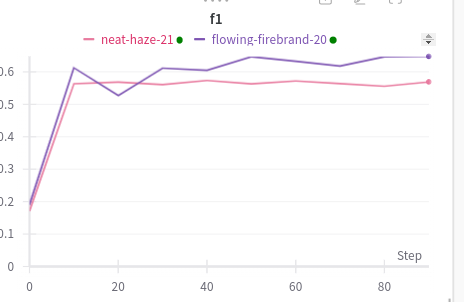

- neat sem a proposta
- flowing com a proposta 